# Pattern Mining of NYC Crime Data with FP-Growth

This notebook builds a reproducible pipeline to mine association rules from the finalized crime dataset using FP-Growth. It includes:

- Global mining on the full dataset
- Conditional rules per Borough and per Time Bucket
- Temporal validation (hold-out) and rolling-window stability checks
- Rule pruning, scoring, and ranking with multiple quality metrics
- Exports of JSON catalogs, CSVs, and human-readable insights

## Setup and Dependencies

Import core libraries, set deterministic options, and configure the environment for pattern mining.

In [1]:
import os
import json
import warnings
from datetime import datetime, timedelta
from pathlib import Path
from typing import List, Optional, Dict
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from tqdm.auto import tqdm
from mlxtend.frequent_patterns import fpgrowth, association_rules
from itertools import combinations

# Deterministic options and clean logs
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.random.seed(42)
print("Libraries imported. Seeds set.")

Libraries imported. Seeds set.


## Paths, Constants, and Parameters

Define input/output paths, key parameters for discretization, and FP-Growth mining configuration.

In [2]:
# --- Path setup ---

base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "JupyterOutputs"))
path_input_dir = os.path.join(base_dir, "Final")
# Use the uncompressed version explicitly
input_csv = os.path.join(path_input_dir, "final_crime_data.csv")

notebook_name = "PatternAnalysis"
path_output = os.path.join(base_dir, notebook_name)
os.makedirs(path_output, exist_ok=True)

# Define uppercase aliases used throughout the notebook for consistency
INPUT_CSV = Path(input_csv)
PATH_OUTPUT = Path(path_output)
NOTEBOOK_NAME = notebook_name

print(f"Project Root: {base_dir}")
print(f"Input CSV: {INPUT_CSV}")
print(f"Output Directory: {PATH_OUTPUT}")

# Top-N category caps (fixed)
TOPN_LOC_OF_OCCUR = 20
TOPN_SUSP_AGE = 10
TOPN_VIC_AGE = 10

# Bins for numeric features (fixed)
DISTANCE_BINS = [0, 250, 1000, float('inf')]
DISTANCE_LABELS = ['<250m', '250-1000m', '>1000m']

# FP-Growth defaults and auto-tuning thresholds (fixed)
GLOBAL_MIN_SUPPORT = 0.5
SLICE_MIN_SUPPORT_RANGE = (0.01, 0.02)
MIN_CONFIDENCE = 0.40
MAX_ITEMSET_LEN = 4
AUTO_MIN_RULES = 150
AUTO_MAX_RULES = 800
AUTO_SUPPORT_BOUNDS = (0.02, 0.20)
AUTO_MAX_ITERS = 10
TOP_K = 50

Project Root: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs
Input CSV: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Final\final_crime_data.csv
Output Directory: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\PatternAnalysis


## Load and Validate Data

Load the finalized dataset, apply temporal filters, and ensure date consistency for downstream analysis.

In [3]:
print(f"Loading data from: {INPUT_CSV}")

# Load from uncompressed file with inferred dtypes (no explicit dtype mapping)
df_raw = pd.read_csv(INPUT_CSV, low_memory=False)
# Drop unneeded identifier and geo columns if present
df_raw.drop(columns=['KY_CD', 'PD_CD', 'Latitude', 'Longitude', 'TO_CHECK_CITIZENS'], errors='ignore', inplace=True)

# Add HAS_POI column: 1 if TOTAL_POI_COUNT > 0, else 0
if 'TOTAL_POI_COUNT' in df_raw.columns:
    df_raw['HAS_POI'] = (df_raw['TOTAL_POI_COUNT'] > 0).astype(int)
    print("HAS_POI column added. Distribution:")
    print(df_raw['HAS_POI'].value_counts())
    df_raw.drop(columns=['TOTAL_POI_COUNT'], errors='ignore', inplace=True)
else:
    print("Warning: TOTAL_POI_COUNT column not found. Setting HAS_POI to 0 for all records.")
    df_raw['HAS_POI'] = 0

# --- Temporal Filter: Keep only data for the year 2024 ---
date_construction_successful = True

if 'YEAR' in df_raw.columns:
    df_raw = df_raw[df_raw['YEAR'] == 2024].copy()

# Always construct DATE from YEAR/MONTH/DAY
for c in ['YEAR', 'MONTH', 'DAY']:
    if c in df_raw.columns:
        df_raw[c] = pd.to_numeric(df_raw[c], errors='coerce')
    else:
        print(f"Warning: {c} column not found. Date construction may be incomplete.")
        df_raw[c] = np.nan

# If DAY is missing or NaN, default to 1 to avoid NaT when only year/month exist
df_raw['DAY'] = df_raw['DAY'].fillna(1)

try:
    df_raw['DATE'] = pd.to_datetime(
        df_raw[['YEAR', 'MONTH', 'DAY']].rename(columns={'YEAR': 'year', 'MONTH': 'month', 'DAY': 'day'}),
        errors='coerce',
    )
    
    # Validate date construction
    invalid_dates_count = df_raw['DATE'].isna().sum()
    if invalid_dates_count > 0:
        print(f"Warning: {invalid_dates_count:,} records have invalid dates and will be excluded from temporal analysis.")
        
except Exception as e:
    print(f"Error during date construction: {e}")
    df_raw['DATE'] = pd.NaT
    date_construction_successful = False

# --- Drop columns not used in this specific analysis to speed up processing ---
unused_cols = [
    'PREM_TYP_DESC', 'POI_DIVERSITY', 'POI_DENSITY_SCORE',
    'IS_WEEKEND', 'IS_HOLIDAY', 'IS_PAYDAY',
    'SAME_AGE_GROUP', 'SAME_SEX', 'OFNS_DESC'
]
df_raw.drop(columns=unused_cols, errors='ignore', inplace=True)

# Materialize analysis DataFrame
df = df_raw.copy()

# Drop invalid dates for temporal analyses
if date_construction_successful:
    initial_count = len(df)
    df.dropna(subset=['DATE'], inplace=True)
    dropped_count = initial_count - len(df)
    if dropped_count > 0:
        print(f"Removed {dropped_count:,} records with invalid dates.")

print(f"Data loaded: {len(df):,} rows after filtering and date construction.")

Loading data from: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Final\final_crime_data.csv
HAS_POI column added. Distribution:
HAS_POI
0    1645219
1     848616
Name: count, dtype: int64
Data loaded: 560,820 rows after filtering and date construction.


### Override Parameters from Diagnostics

Apply overrides for Top-N caps and binning if suggested by the diagnostics profile.

In [4]:
# Diagnostics directory path
PATH_DIAGNOSTICS = PATH_OUTPUT / 'Diagnostics'
PROFILE = {}

profile_path = PATH_DIAGNOSTICS / 'profile_summary.json'
if profile_path.exists():
    try:
        with open(profile_path, 'r', encoding='utf-8') as f:
            PROFILE = json.load(f)
        print(f"Diagnostics profile loaded from: {profile_path}")
        # Quick sanity: show suggested top-N caps if present
    except Exception as e:
        print(f"Warning: Failed to read diagnostics profile: {e}")
else:
    print("No diagnostics profile found; proceeding without external guidance.")

# Use Top-N suggestions from PROFILE when present; otherwise keep current defaults
if isinstance(PROFILE, dict) and PROFILE.get('topn_suggestions'):
    info = PROFILE['topn_suggestions']
    # Map notebook vars -> profile keys
    prev_vals = (TOPN_LOC_OF_OCCUR, TOPN_SUSP_AGE, TOPN_VIC_AGE)
    TOPN_LOC_OF_OCCUR = int(info.get('LOC_OF_OCCUR_DESC', {}).get('top_n', TOPN_LOC_OF_OCCUR))
    TOPN_SUSP_AGE = int(info.get('SUSP_AGE_GROUP', {}).get('top_n', TOPN_SUSP_AGE))
    TOPN_VIC_AGE = int(info.get('VIC_AGE_GROUP', {}).get('top_n', TOPN_VIC_AGE))
    if prev_vals != (TOPN_LOC_OF_OCCUR, TOPN_SUSP_AGE, TOPN_VIC_AGE):
        applied.append('Top-N caps')

applied = []

# Adopt binning from Diagnostics if consistent and safe
if isinstance(PROFILE, dict) and PROFILE.get('proposed_bins'):
    pb = PROFILE['proposed_bins']

    # Helper to safely adopt shared bins and labels
    def adopt_bins_and_labels(section_key, current_bins, current_labels):
        section = pb.get(section_key)
        if not isinstance(section, dict) or not section:
            return current_bins, current_labels, False
        # Collect candidate bins/labels
        bins_list = []
        labels_list = []
        for v in section.values():
            if isinstance(v, dict):
                b = v.get('bins')
                l = v.get('labels')
                if isinstance(b, list):
                    bins_list.append(b)
                if isinstance(l, list):
                    labels_list.append(l)
        changed = False
        # If all bins proposals are identical and lengths match labels, adopt
        if bins_list and all(b == bins_list[0] for b in bins_list):
            new_bins = bins_list[0]
            # Labels adoption optional but must match in length
            new_labels = current_labels
            if labels_list and all(l == labels_list[0] for l in labels_list):
                if len(labels_list[0]) == len(current_labels):
                    new_labels = labels_list[0]
            # Extra safety: ensure cut compatibility
            if isinstance(new_bins, list) and len(new_bins) >= 2 and len(new_labels) == len(current_labels):
                return new_bins, new_labels, True
        return current_bins, current_labels, changed

    # Distances
    DISTANCE_BINS, DISTANCE_LABELS, ch1 = adopt_bins_and_labels('distances', DISTANCE_BINS, DISTANCE_LABELS)
    if ch1:
        applied.append('Distance bins/labels')

print(f"Diagnostics-driven overrides applied: {', '.join(applied) if applied else 'none'}.")

Diagnostics profile loaded from: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\PatternAnalysis\Diagnostics\profile_summary.json
Diagnostics-driven overrides applied: Distance bins/labels.


## Data Readiness and Discretization

Summarize the columns removed for performance, and outline the main preprocessing steps: normalization, capping, binning, boolean flag creation, and data quality validation.

## Preprocess Categorical Features

Normalize and cap main categorical features, unify borough labels, and save the set of retained categories for transparency and reproducibility.

In [5]:
def norm_cap(df_in: pd.DataFrame, col: str, top_n: int | None) -> pd.Series:
    if col not in df_in.columns:
        return pd.Series(['UNKNOWN'] * len(df_in), index=df_in.index, dtype='category')
    s = df_in[col].astype('string').fillna('UNKNOWN').str.strip().str.upper()
    if top_n is None:
        return s.astype('category')
    top = s.value_counts().nlargest(top_n).index
    return s.where(s.isin(top), 'OTHER').astype('category')

# Process main categorical features
retained_categories = {}
df_proc = pd.DataFrame(index=df.index)

cfg = {
    'LOC_OF_OCCUR': ( 'LOC_OF_OCCUR_DESC', TOPN_LOC_OF_OCCUR ),
    'SUSP_AGE': ( 'SUSP_AGE_GROUP', TOPN_SUSP_AGE ),
    'VIC_AGE': ( 'VIC_AGE_GROUP', TOPN_VIC_AGE ),
    'LAW_CAT': ( 'LAW_CAT_CD', None ),
    'SUSP_RACE': ( 'SUSP_RACE', None ),
    'SUSP_SEX': ( 'SUSP_SEX', None ),
    'VIC_RACE': ( 'VIC_RACE', None ),
    'VIC_SEX': ( 'VIC_SEX', None ),
    'SEASON': ( 'SEASON', None ),
    'TIME_BUCKET': ( 'TIME_BUCKET', None ),
}

for new_name, (src, topn) in cfg.items():
    if src in df.columns:
        df_proc[new_name] = norm_cap(df, src, topn)
        retained_categories[new_name] = sorted(df_proc[new_name].cat.categories.tolist())
    else:
        print(f"Warning: Source column '{src}' for '{new_name}' not found. Setting to UNKNOWN.")
        df_proc[new_name] = pd.Series(['UNKNOWN'] * len(df), index=df.index, dtype='category')
        retained_categories[new_name] = ['UNKNOWN']

# HAS_POI column: binary categorical
if 'HAS_POI' in df.columns:
    df_proc['HAS_POI'] = df['HAS_POI'].map({1: 'YES', 0: 'NO'}).fillna('UNKNOWN').astype('category')
    retained_categories['HAS_POI'] = sorted(df_proc['HAS_POI'].cat.categories.tolist())
else:
    print("Warning: 'HAS_POI' not found in df. Setting to UNKNOWN.")
    df_proc['HAS_POI'] = pd.Series(['UNKNOWN'] * len(df), index=df.index, dtype='category')
    retained_categories['HAS_POI'] = ['UNKNOWN']

# BORO unified: source column is BORO_NM
if 'BORO_NM' in df.columns:
    df_proc['BORO'] = df['BORO_NM'].astype('string').fillna('UNKNOWN').str.strip().str.upper().astype('category')
    retained_categories['BORO'] = sorted(df_proc['BORO'].cat.categories.tolist())
else:
    print("Warning: 'BORO_NM' not found as expected. 'BORO' column will be all UNKNOWN.")
    df_proc['BORO'] = pd.Series(['UNKNOWN'] * len(df), index=df.index, dtype='category')
    retained_categories['BORO'] = ['UNKNOWN']
    
# Save retained categories for transparency
with open(PATH_OUTPUT / 'retained_categories.json', 'w', encoding='utf-8') as f:
    json.dump(retained_categories, f, indent=2, sort_keys=True)

# Validate that we have meaningful data
meaningful_features = 0
for feature, categories in retained_categories.items():
    if len(categories) > 1 and 'UNKNOWN' not in categories:
        meaningful_features += 1
    elif len(categories) == 1 and categories[0] == 'UNKNOWN':
        print(f"Warning: Feature '{feature}' contains only UNKNOWN values.")

print(f"Created {len(retained_categories)} categorical features, {meaningful_features} have meaningful variation.")

if PROFILE and 'topn_suggestions' in PROFILE:
    print('Top-N guidance (from Diagnostics):')
    for k, info in PROFILE['topn_suggestions'].items():
        print(f"  - {k}: top {info['top_n']} cover {info['coverage_pct']:.1f}%")

print("Categorical preprocessing completed.")

Created 12 categorical features, 7 have meaningful variation.
Top-N guidance (from Diagnostics):
  - OFNS_DESC: top 30 cover 99.4%
  - PREM_TYP_DESC: top 25 cover 95.1%
  - LOC_OF_OCCUR_DESC: top 20 cover 100.0%
  - SUSP_AGE_GROUP: top 10 cover 100.0%
  - VIC_AGE_GROUP: top 10 cover 100.0%
Categorical preprocessing completed.


## Engineer Time, Distance, and Count Buckets

Create engineered bins for time and distance features, using available columns and diagnostics-driven binning if present. Standardize missing values and validate feature distributions.

In [6]:
df_proc['DATE'] = df['DATE']

# TIME_BUCKET normalized: prefer existing column, normalized to uppercase strings
if 'TIME_BUCKET' in df.columns:
    s_tb = df['TIME_BUCKET'].astype('string').fillna('UNKNOWN').str.strip().str.upper()
    df_proc['TIME_BUCKET'] = s_tb.astype('category')
    print(f"TIME_BUCKET found in data. Distribution: {df_proc['TIME_BUCKET'].value_counts().to_dict()}")
else:
    # Fallback if TIME_BUCKET is missing: derive from HOUR
    if 'HOUR' in df.columns:
        hours = pd.to_numeric(df['HOUR'], errors='coerce').fillna(0).astype(int).clip(0, 23)
        HOUR_BUCKETS_LOCAL = {
            'NIGHT': range(0, 6), 'MORNING': range(6, 12),
            'AFTERNOON': range(12, 18), 'EVENING': range(18, 24)
        }
        bucket_map = {h: name for name, rng in HOUR_BUCKETS_LOCAL.items() for h in rng}
        df_proc['TIME_BUCKET'] = hours.map(bucket_map).fillna('NIGHT').astype('category')
        print("TIME_BUCKET derived from HOUR column.")
    else:
        df_proc['TIME_BUCKET'] = pd.Series(['UNKNOWN'] * len(df), index=df.index, dtype='category')
        print("Warning: Neither TIME_BUCKET nor HOUR found. Setting TIME_BUCKET to UNKNOWN.")

# Numeric bin helpers
def bin_numeric(df_in: pd.DataFrame, col: str | None, bins: list, labels: list, default: str) -> pd.Series:
    if col is None or col not in df_in.columns:
        return pd.Series([default] * len(df_in), index=df_in.index, dtype='category')
    vals = pd.to_numeric(df_in[col], errors='coerce')
    try:
        cut = pd.cut(vals, bins=bins, labels=labels, include_lowest=True)
        return cut.cat.add_categories([default]).fillna(default).astype('category')
    except Exception as e:
        print(f"Warning: Binning failed for {col}: {e}")
        return pd.Series([default] * len(df_in), index=df_in.index, dtype='category')

# Optional quantile binning for skewed metrics
def bin_quantiles(df_in: pd.DataFrame, col: str | None, q: int, labels: list[str] | None = None, default: str = 'UNKNOWN') -> pd.Series:
    if col is None or col not in df_in.columns:
        return pd.Series([default] * len(df_in), index=df_in.index, dtype='category')
    vals = pd.to_numeric(df_in[col], errors='coerce')
    try:
        qcut = pd.qcut(vals, q=q, labels=labels if labels is not None else False, duplicates='drop')
        if labels is None and hasattr(qcut, 'cat'):
            qcut = qcut.cat.rename_categories([f'Q{i+1}' for i in range(qcut.cat.categories.size)])
        return qcut.astype('category').cat.add_categories([default]).fillna(default)
    except Exception as e:
        print(f"Warning: Quantile binning failed for {col}: {e}")
        return pd.Series([default] * len(df_in), index=df_in.index, dtype='category')

# --- Binning for Numeric Features ---
# Use the first available column from the list as the primary source
def find_first_col(df_in: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    found_cols = [c for c in candidates if c in df_in.columns]
    if found_cols:
        print(f"Distance columns available: {found_cols}")
        return found_cols[0]
    else:
        print(f"Warning: No distance columns found from candidates: {candidates}")
        return None

engineered_features = []

# Distance Bins (primary distance proxy)
dist_candidates = ['MIN_POI_DISTANCE', 'AVG_POI_DISTANCE', 'MAX_POI_DISTANCE', 'BAR_DISTANCE', 'METRO_DISTANCE', 'NIGHTCLUB_DISTANCE', 'ATM_DISTANCE']
primary_dist = find_first_col(df, dist_candidates)
df_proc['DIST_BIN'] = bin_numeric(df, primary_dist, DISTANCE_BINS, DISTANCE_LABELS, 'UNKNOWN')
engineered_features.append('DIST_BIN')

if primary_dist:
    print(f"Using '{primary_dist}' for distance binning. Distribution: {df_proc['DIST_BIN'].value_counts().to_dict()}")
else:
    print("Warning: No distance columns available for binning. DIST_BIN will be all UNKNOWN.")

print("Feature engineering completed.")
print(f"Engineered features created: {engineered_features}")
print(f"Diagnostics-driven overrides applied: {', '.join(applied) if applied else 'none'}.")

TIME_BUCKET found in data. Distribution: {'AFTERNOON': 191903, 'EVENING': 172881, 'MORNING': 111800, 'NIGHT': 84236}
Distance columns available: ['MIN_POI_DISTANCE', 'AVG_POI_DISTANCE', 'MAX_POI_DISTANCE', 'BAR_DISTANCE', 'METRO_DISTANCE', 'NIGHTCLUB_DISTANCE', 'ATM_DISTANCE']
Using 'MIN_POI_DISTANCE' for distance binning. Distribution: {'<250m': 280722, '250-1000m': 234305, '>1000m': 45793, 'UNKNOWN': 0}
Feature engineering completed.
Engineered features created: ['DIST_BIN']
Diagnostics-driven overrides applied: Distance bins/labels.


## Build Transactional One-Hot Encoding

Transform the processed features into a transactional one-hot encoded matrix, suitable for FP-Growth mining, and add context columns for downstream conditional analyses.

In [7]:
# Define all engineered and preprocessed features to be used for mining
item_cols_for_mining = [
    # Core Crime Descriptors
    'LAW_CAT', 'LOC_OF_OCCUR',
    # Geographic & Temporal Context
    'BORO', 'TIME_BUCKET', 'SEASON',
    # Suspect & Victim Demographics
    'SUSP_AGE', 'SUSP_RACE', 'SUSP_SEX',
    'VIC_AGE', 'VIC_RACE', 'VIC_SEX',
    # Engineered Bins
    'DIST_BIN',
    # Engineered Boolean/Flags
    'HAS_POI',
]

# Filter to only include columns that actually exist in the processed DataFrame
present_cols = [c for c in item_cols_for_mining if c in df_proc.columns]
missing_cols = [c for c in item_cols_for_mining if c not in df_proc.columns]

if missing_cols:
    print(f"Warning: Missing columns for mining: {missing_cols}")
    
print(f"Columns selected for one-hot encoding ({len(present_cols)}/{len(item_cols_for_mining)}): {present_cols}")

if not present_cols:
    raise ValueError("No valid columns found for pattern mining. Check data preprocessing.")

print("Constructing item lists for one-hot encoding...")
# Create series of "KEY=VALUE" strings, e.g., "BORO=BRONX"
item_series = [df_proc[c].astype(str).apply(lambda v: f"{c}={v}") for c in present_cols]

if item_series:
    items_df = pd.concat(item_series, axis=1)

    # Stack all item strings into a single series
    stacked = items_df.stack()
    print(f"Total item instances before filtering: {len(stacked):,}")
    
    # Remove items with UNKNOWN values to reduce noise
    stacked = stacked[~stacked.str.endswith('=UNKNOWN')]
    print(f"Item instances after removing UNKNOWN: {len(stacked):,}")
    
    if not stacked.empty:
        # Efficiently create the one-hot encoded matrix
        booleans = pd.get_dummies(stacked, prefix='', prefix_sep='').groupby(level=0).sum().astype(bool)
        # Remove any potential duplicate columns that might arise
        booleans = booleans.loc[:, ~booleans.columns.duplicated()]
        print(f"One-hot encoding successful. Matrix shape: {booleans.shape}")
    else:
        print("ERROR: No valid items to encode after filtering UNKNOWNs. Check data quality.")
        booleans = pd.DataFrame(index=df_proc.index)
else:
    print("ERROR: No item columns found to process.")
    booleans = pd.DataFrame(index=df_proc.index)

# Ensure the index matches the original DataFrame for alignment
booleans = booleans.reindex(df_proc.index, fill_value=False)

# Add special context columns (prefixed with '__') for filtering during analysis
booleans['__DATE__'] = df_proc['DATE']
booleans['__BORO__'] = df_proc['BORO']
booleans['__TIME_BUCKET__'] = df_proc['TIME_BUCKET']

print(f"One-hot encoded matrix shape: {booleans.shape}")
mining_cols_count = len([c for c in booleans.columns if not c.startswith('__')])
print(f"Number of unique items for mining: {mining_cols_count}")

Columns selected for one-hot encoding (13/13): ['LAW_CAT', 'LOC_OF_OCCUR', 'BORO', 'TIME_BUCKET', 'SEASON', 'SUSP_AGE', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE', 'VIC_RACE', 'VIC_SEX', 'DIST_BIN', 'HAS_POI']
Constructing item lists for one-hot encoding...
Total item instances before filtering: 7,290,660
Item instances after removing UNKNOWN: 6,406,567
One-hot encoding successful. Matrix shape: (560820, 55)
One-hot encoded matrix shape: (560820, 58)
Number of unique items for mining: 55


## FP-Growth Mining with Auto-Tuning

Define FP-Growth mining functions with automatic support tuning to control rule set size.

In [8]:
def mine_fpgrowth(df_bool: pd.DataFrame, min_support: float, min_conf: float, use_cols: Optional[List[str]] = None, max_len: int = MAX_ITEMSET_LEN):
    """
    Runs the FP-Growth algorithm on a one-hot encoded DataFrame with robust error handling.
    """
    cols = use_cols or [c for c in df_bool.columns if not c.startswith('__')]
    if not cols:
        print("Warning: No columns available for FP-Growth mining.")
        return pd.DataFrame(), pd.DataFrame()

    basket = df_bool[cols]
    if basket.dtypes.ne(bool).any():
        basket = basket.astype(bool)

    # Check if basket has sufficient support for any itemsets
    col_support = basket.mean()
    valid_cols = col_support[col_support >= min_support].index.tolist()
    
    if not valid_cols:
        print(f"Warning: No columns meet minimum support threshold of {min_support:.4f}")
        return pd.DataFrame(), pd.DataFrame()
    
    if len(valid_cols) < len(cols):
        print(f"Filtering columns: {len(valid_cols)}/{len(cols)} columns meet support threshold")
        basket = basket[valid_cols]

    # Limit search space and show progress
    try:
        frequent_itemsets = fpgrowth(basket, min_support=min_support, use_colnames=True, max_len=max_len)
    except TypeError:
        # Fallback for older mlxtend versions without max_len
        frequent_itemsets = fpgrowth(basket, min_support=min_support, use_colnames=True)
    except Exception as e:
        print(f"Error during FP-Growth: {e}")
        return pd.DataFrame(), pd.DataFrame()

    if frequent_itemsets.empty:
        print(f"No frequent itemsets found with min_support={min_support:.4f}")
        return frequent_itemsets, pd.DataFrame()
    
    try:
        with np.errstate(divide='ignore', invalid='ignore'):
            rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_conf)
    except Exception as e:
        print(f"Error generating association rules: {e}")
        return frequent_itemsets, pd.DataFrame()
    
    print(f"FP-Growth completed: {len(frequent_itemsets)} itemsets, {len(rules)} rules")
    return frequent_itemsets, rules


def auto_tune_support(df_bool: pd.DataFrame, 
                      target_range=(AUTO_MIN_RULES, AUTO_MAX_RULES),
                      support_bounds=AUTO_SUPPORT_BOUNDS, 
                      init_support=GLOBAL_MIN_SUPPORT,
                      min_conf=MIN_CONFIDENCE, 
                      use_cols: Optional[List[str]] = None,
                      context_name: str = "global"):
    """
    Automatically adjusts the min_support threshold to find a number of rules
    within a specified target range using a binary-search-like approach.
    """
    lo_support, hi_support = support_bounds
    min_rules, max_rules = target_range
    
    # Validate input parameters
    if lo_support >= hi_support:
        print(f"Error: Invalid support bounds ({lo_support}, {hi_support})")
        return lo_support, pd.DataFrame(), pd.DataFrame()
    
    if len(df_bool) < 50:
        print(f"Warning: Dataset too small for reliable mining ({len(df_bool)} records)")
        return lo_support, pd.DataFrame(), pd.DataFrame()
    
    best_support = float(np.clip(init_support, lo_support, hi_support))
    best_rules_count = -1
    best_freq = pd.DataFrame()
    best_rules = pd.DataFrame()
    
    print(f"Auto-tuning for '{context_name}' with target rule range ({min_rules}, {max_rules})...")
    print(f"Dataset size: {len(df_bool):,} records")

    for i in range(AUTO_MAX_ITERS):
        support = (lo_support + hi_support) / 2
        
        freq, rules = mine_fpgrowth(df_bool, support, min_conf, use_cols)
        n_rules = len(rules)
        
        print(f"[DEBUG] Iter {i+1}/{AUTO_MAX_ITERS}: support={support:.5f} -> rules={n_rules}")

        # Store the best result found so far that is closest to the target range
        if best_rules_count == -1 or abs(n_rules - min_rules) < abs(best_rules_count - min_rules):
            best_support = support
            best_rules_count = n_rules
            best_freq = freq.copy() if not freq.empty else pd.DataFrame()
            best_rules = rules.copy() if not rules.empty else pd.DataFrame()

        if min_rules <= n_rules <= max_rules:
            print(f"Success: Found {n_rules} rules within target range.")
            return support, freq, rules
        
        if n_rules < min_rules:
            hi_support = support  # Decrease support to find more rules
        else: # n_rules > max_rules
            lo_support = support  # Increase support to find fewer rules
        
        if (hi_support - lo_support) < 1e-5:
            print("Warning: Support range is very narrow. Stopping early.")
            break
    else:
        print(f"Warning: Auto-tuning for '{context_name}' finished after {AUTO_MAX_ITERS} iterations without converging.")

    # Fallback: try with very low support if no rules found
    if best_rules_count == 0 and lo_support > 0.001:
        print(f"Attempting fallback with very low support (0.001) for '{context_name}'...")
        fallback_freq, fallback_rules = mine_fpgrowth(df_bool, 0.001, min_conf, use_cols)
        if len(fallback_rules) > 0:
            print(f"Fallback successful: {len(fallback_rules)} rules found.")
            return 0.001, fallback_freq, fallback_rules

    print(f"Auto-tune for '{context_name}': final support={best_support:.5f}, rules found={best_rules_count}")
    return best_support, best_freq, best_rules

## Generate Association Rule Metrics

Compute additional metrics for each discovered rule, including conviction and the Kulczynski metric, to enhance rule evaluation and ranking.

In [9]:
def add_additional_metrics(rules_df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes additional, useful metrics for evaluating association rules,
    such as conviction and Kulczynski metric.
    """
    if rules_df.empty:
        return rules_df
        
    rules = rules_df.copy()
    eps = 1e-9  # Small epsilon to avoid division by zero

    # --- Conviction ---
    # Measures how much a consequent depends on the antecedent.
    # High conviction means the rule is very strong.
    conf = rules['confidence'].clip(eps, 1 - eps)
    rules['conviction'] = (1 - rules['consequent support']) / (1 - conf)

    # --- Kulczynski Metric ---
    # Kulczynski = 0.5 * (P(B|A) + P(A|B))
    # P(B|A) = confidence
    # P(A|B) = support(A and B) / support(B) = support / [consequent support]
    kulczynski = 0.5 * (
        rules['confidence'] +
        (rules['support'] / rules['consequent support'].clip(lower=eps))
    )
    rules["kulczynski"] = kulczynski.fillna(0)

    return rules

## Prune Redundant Rules and Rank Top-K

Remove duplicate and subsumed rules, then score and rank the top-K rules using **Maximal Marginal Significance (MMS)**, which maximizes diversity among the selected rules, with the Kulczynski metric as the primary criterion for reporting and export.

In [10]:
def canonicalize_rule(row):
    """Creates a canonical, hashable representation of a rule."""
    antecedent = tuple(sorted(map(str, row['antecedents']))) if row['antecedents'] else ()
    consequent = tuple(sorted(map(str, row['consequents']))) if row['consequents'] else ()
    return (antecedent, consequent)


def prune_redundant_rules(rules_df: pd.DataFrame, conf_tol=1e-6, lift_tol=1e-6) -> pd.DataFrame:
    """
    Prunes rules that are either duplicates or are subsumed by more general,
    stronger rules.
    """
    if rules_df.empty:
        return rules_df
        
    rules = rules_df.copy()
    
    # 1. Remove exact duplicates based on canonical representation
    rules['key'] = rules.apply(canonicalize_rule, axis=1)
    rules.drop_duplicates(subset=['key'], inplace=True)
    
    # 2. Prune by subsumption
    # A rule A -> C is subsumed by B -> C if B is a subset of A and the
    # metrics of A -> C are not significantly better.
    to_drop = set()
    # Sort by consequent, then by metrics to process related rules together
    rules['consequents_tuple'] = rules['consequents'].apply(lambda s: tuple(sorted(s)))
    rules.sort_values(by=['consequents_tuple', 'confidence', 'lift'],
                      ascending=[True, False, False],
                      inplace=True)

    grouped = rules.groupby('consequents_tuple')
    
    for _, group in grouped:
        # Compare each rule with every other rule in the same consequent group
        for i, j in combinations(group.index, 2):
            if i in to_drop or j in to_drop:
                continue
            
            rule1, rule2 = group.loc[i], group.loc[j]
            ant1, ant2 = set(rule1['antecedents']), set(rule2['antecedents'])
            
            # Check for subsumption
            if ant1.issubset(ant2):  # rule2 has a more specific antecedent
                # If rule2 is not significantly better, it's redundant
                if rule2['confidence'] <= rule1['confidence'] + conf_tol and \
                   rule2['lift'] <= rule1['lift'] + lift_tol:
                    to_drop.add(j)
            elif ant2.issubset(ant1):  # rule1 has a more specific antecedent
                # If rule1 is not significantly better, it's redundant
                if rule1['confidence'] <= rule2['confidence'] + conf_tol and \
                   rule1['lift'] <= rule2['lift'] + lift_tol:
                    to_drop.add(i)

    pruned = rules.drop(index=list(to_drop))
    return pruned.drop(columns=['key', 'consequents_tuple'], errors='ignore')


def score_and_rank_rules_mms(rules_df: pd.DataFrame, top_k: int = TOP_K) -> pd.DataFrame:
    """
    Selects the top-K rules using Maximal Marginal Significance (MMS):
    - Orders by score (Kulczynski × sqrt(support))
    - Adds a rule only if its marginal coverage (new items) is sufficient compared to already selected rules
    """
    if rules_df.empty:
        return rules_df

    r = rules_df.copy()
    r['score'] = r['kulczynski'] * np.sqrt(r['support'])
    r = r[
        (r['kulczynski'] > 0.4) &
        (r['lift'] > 1.01) &
        (r['confidence'] > 0.4)
    ]

    def is_trivial_rule(row):
        trivial_terms = {
            'HAS_POI=NO', 'HAS_POI=YES',
            'DIST_BIN=250-1000m', 'DIST_BIN=<250m', 'DIST_BIN=>1000m',
        }
        ant = set(map(str, row['antecedents']))
        con = set(map(str, row['consequents']))
        if (ant | con) <= trivial_terms:
            return True
        if ant & trivial_terms and con & trivial_terms:
            return True
        return False

    r = r[~r.apply(is_trivial_rule, axis=1)]
    r.sort_values(by=['score', 'confidence', 'support'], ascending=[False, False, False], inplace=True)

    # MMS selection
    selected = []
    covered = set()
    for _, row in r.iterrows():
        rule_items = set(map(str, row['antecedents'])) | set(map(str, row['consequents']))
        # Add only if at least one new item is covered
        if not rule_items <= covered:
            selected.append(row)
            covered |= rule_items
        if len(selected) >= top_k:
            break

    return pd.DataFrame(selected)

def rules_to_records(rules_df: pd.DataFrame, context: str, tuned_support: float) -> List[dict]:
    """
    Converts a DataFrame of rules into a list of structured dictionaries
    for easy serialization (e.g., to JSON).
    """
    records = []
    for _, row in rules_df.iterrows():
        records.append({
            'context': context,
            'antecedent': sorted(map(str, row['antecedents'])),
            'consequent': sorted(map(str, row['consequents'])),
            'support': float(row.get('support', 0)),
            'confidence': float(row.get('confidence', 0)),
            'lift': float(row.get('lift', 0)),
            'leverage': float(row.get('leverage', 0)),
            'conviction': float(row.get('conviction', 0)),
            'zhangs_metric': float(row.get("zhang's_metric", 0)),
            'score': float(row.get('score', 0)),
            'min_support_used': float(tuned_support),
        })
    return records

## Global Mining, Reporting, and Export

Run association rule mining on the full dataset, filter and rank rules primarily by the Kulczynski metric, and export results as JSON, CSV, and human-readable insights.

In [11]:
def run_global_mining_and_export(df_bool: pd.DataFrame) -> dict:
    """
    Orchestrates the end-to-end process for global rule mining:
    - Auto-tunes support
    - Calculates metrics
    - Prunes and ranks rules
    - Exports all artifacts (JSON, CSV, insights)
    """
    print("--- Starting Global Mining ---")

    tuned_support, _, all_rules = auto_tune_support(
        df_bool,
        init_support=0.15,
        support_bounds=AUTO_SUPPORT_BOUNDS,
        context_name="global"
    )

    if all_rules.empty:
        print("Global mining yielded no rules. Aborting export.")
        return {}

    all_rules = add_additional_metrics(all_rules)
    pruned_rules = prune_redundant_rules(all_rules)
    ranked_rules = score_and_rank_rules_mms(pruned_rules, top_k=TOP_K)
    
    print(f"Found {len(all_rules):,} rules, pruned to {len(pruned_rules):,}, ranked top {len(ranked_rules)}.")

    # --- Export JSON Catalog ---
    global_catalog = {
        'context': 'global',
        'tuned_min_support': tuned_support,
        'total_rules_found': len(all_rules),
        'pruned_rules_count': len(pruned_rules),
        'top_k_rules': rules_to_records(ranked_rules, 'global', tuned_support)
    }
    catalog_path = PATH_OUTPUT / 'global_rules.json'
    with open(catalog_path, 'w', encoding='utf-8') as f:
        json.dump(global_catalog, f, indent=2)

    # --- Export Human-Readable Insights ---
    insights_path = PATH_OUTPUT / 'global_insights.txt'
    with open(insights_path, 'w', encoding='utf-8') as f:
        f.write("--- Top-K Global Association Rules ---\n\n")
        for _, r in ranked_rules.iterrows():
            ant = " AND ".join(sorted(map(str, r['antecedents'])))
            con = " AND ".join(sorted(map(str, r['consequents'])))
            insight = (
                f"IF ({ant}) THEN ({con})\n"
                f"  - Kulc: {r['kulczynski']:.3f}, Confidence: {r['confidence']:.2%}, Lift: {r['lift']:.2f}, "
                f"Support: {r['support']:.4f}, Score: {r.get('score', 0):.3f}\n\n"
            )
            f.write(insight)

    # --- Export Top-K Rules to CSV for easy analysis ---
    csv_path = PATH_OUTPUT / 'global_topk_rules.csv'
    ranked_rules.to_csv(csv_path, index=False)

    print(f"Global mining artifacts exported to: {PATH_OUTPUT}")
    
    return {
        'tuned_support': tuned_support,
        'all_rules': all_rules,
        'pruned_rules': pruned_rules,
        'ranked_rules': ranked_rules
    }

# Execute the global mining process
GLOBAL_RESULTS = run_global_mining_and_export(booleans)

--- Starting Global Mining ---
Auto-tuning for 'global' with target rule range (150, 800)...
Dataset size: 560,820 records
Filtering columns: 37/55 columns meet support threshold
FP-Growth completed: 228 itemsets, 294 rules
[DEBUG] Iter 1/10: support=0.11000 -> rules=294
Success: Found 294 rules within target range.
Found 294 rules, pruned to 235, ranked top 27.
Global mining artifacts exported to: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\PatternAnalysis


### Visualize Top-K Global Rules

Display a bar chart of the top-K global rules, visualizing their composite score, confidence, and lift for quick interpretation of the most important patterns.

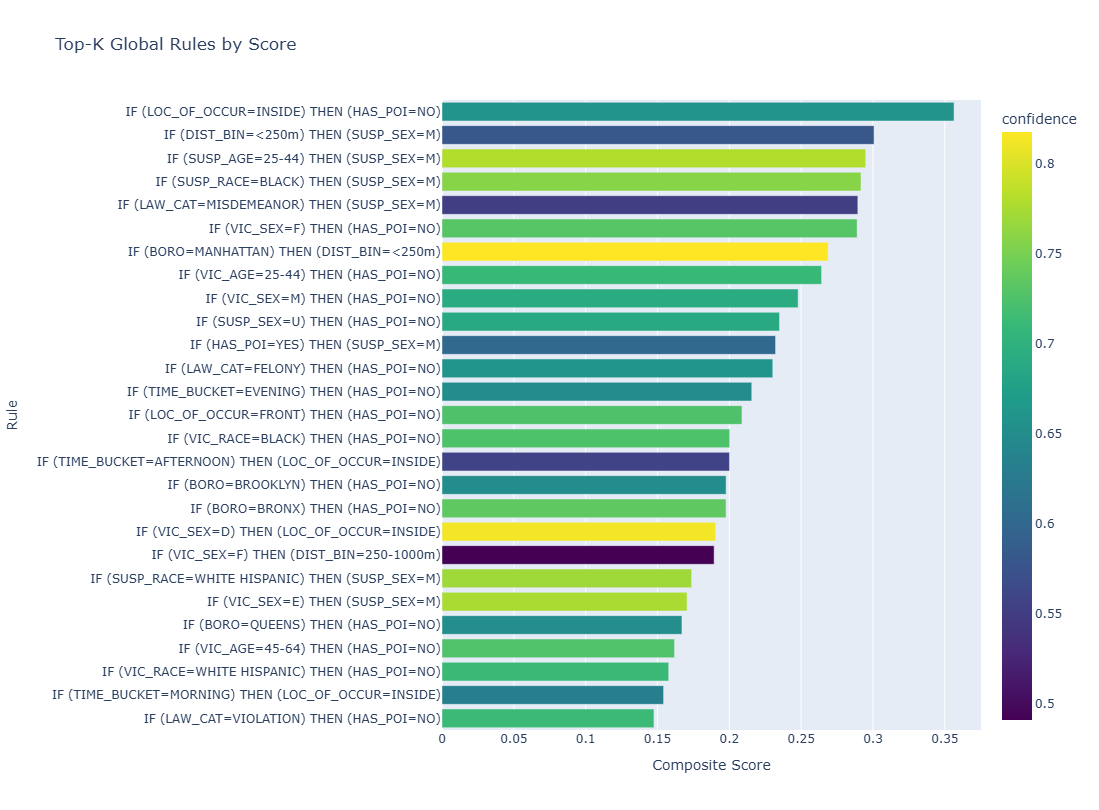

In [12]:
def plot_top_k_rules(ranked_rules: pd.DataFrame):
    """
    Generates and displays a bar chart for the top-K rules, showing their
    score, confidence, and lift.
    """
    if ranked_rules.empty:
        print("Cannot plot rules: DataFrame is empty.")
        return

    # Create a human-readable label for each rule
    ranked_rules['rule_label'] = ranked_rules.apply(
        lambda r: f"IF ({' & '.join(sorted(map(str, r['antecedents'])))}) THEN ({' & '.join(sorted(map(str, r['consequents'])))})",
        axis=1
    )

    fig = px.bar(
        ranked_rules.sort_values('score', ascending=True),
        x='score',
        y='rule_label',
        orientation='h',
        title='Top-K Global Rules by Score',
        labels={'score': 'Composite Score', 'rule_label': 'Association Rule'},
        hover_data=['confidence', 'lift', 'support'],
        color='confidence',
        color_continuous_scale=px.colors.sequential.Viridis,
        height=max(400, len(ranked_rules) * 30) # Dynamic height
    )
    fig.update_layout(
        yaxis={'categoryorder':'total ascending'},
        xaxis_title="Composite Score",
        yaxis_title="Rule",
        margin=dict(l=400) # Adjust left margin to prevent label cutoff
    )
    fig.show()

# Visualize the top-K rules from the global mining results
if 'ranked_rules' in GLOBAL_RESULTS and not GLOBAL_RESULTS['ranked_rules'].empty:
    plot_top_k_rules(GLOBAL_RESULTS['ranked_rules'])
else:
    print("No ranked rules available to plot.")

## Per-Borough Conditional Rules

Mine and export association rules for each borough, excluding trivial rules, and generate contextual insights for each.

In [13]:
def mine_contextual_rules(df_bool: pd.DataFrame, context_col: str, context_name: str):
    """
    Mines association rules for each unique value in a given context column (e.g., for each borough).
    """
    catalog = []
    
    if f'__{context_col}__' not in df_bool.columns:
        print(f"Error: Context column '__{context_col}__' not found in boolean DataFrame.")
        return catalog
    
    context_values = sorted(df_bool[f'__{context_col}__'].dropna().unique())
    
    if not context_values:
        print(f"Warning: No valid values found in context column '{context_col}'.")
        return catalog
    
    # Exclude the context column itself from the items to be mined to avoid trivial rules
    all_mining_cols = [c for c in df_bool.columns if not c.startswith('__')]
    
    print(f"Mining {context_name} rules for {len(context_values)} values: {context_values}")
    
    for value in tqdm(context_values, desc=f"Mining per-{context_name}"):
        mask = (df_bool[f'__{context_col}__'] == value)
        subset = df_bool.loc[mask]
        
        # Skip if the subset is too small for meaningful analysis
        min_records = max(200, len(df_bool) * 0.01)  # At least 1% of data or 200 records
        if len(subset) < min_records:
            print(f"Skipping {context_name} '{value}': insufficient records ({len(subset)} < {min_records:.0f}).")
            continue

        # Define items to use for this specific context, excluding any item related to the context value itself
        # This prevents rules like IF (X) -> (BORO=BROOKLYN) when mining only for Brooklyn.
        item_prefix_to_exclude = f"{context_col.upper()}="
        contextual_mining_cols = [
            c for c in all_mining_cols if not c.startswith(item_prefix_to_exclude)
        ]
        
        if not contextual_mining_cols:
            print(f"Warning: No valid mining columns for {context_name} '{value}' after filtering.")
            continue
            
        # Auto-tune support for this specific slice of data using faster bounds
        init_support = np.clip(SLICE_MIN_SUPPORT_RANGE[0], *AUTO_SUPPORT_BOUNDS)
        tuned_supp, _, rules = auto_tune_support(
            subset, 
            init_support=init_support, 
            support_bounds=AUTO_SUPPORT_BOUNDS,
            context_name=f"{context_name}:{value}",
            use_cols=contextual_mining_cols
        )
        
        if rules.empty:
            print(f"No rules found for {context_name} '{value}' with support >= {tuned_supp:.4f}.")
            continue

        rules = add_additional_metrics(rules)
        rules_p = prune_redundant_rules(rules)
        rules_k = score_and_rank_rules_mms(rules_p, TOP_K)

        context_label = f'{context_name}:{value}'
        catalog.append({
            'context': context_label,
            'value': value,
            'records_count': len(subset),
            'min_support_used': tuned_supp,
            'rule_count': len(rules_p),
            'top_k_rules': rules_to_records(rules_k, context_label, tuned_supp)
        })

        # --- Export insights for this specific context ---
        context_slug = f"{context_name}_{str(value).replace(' ', '_')}"
        insights_path = PATH_OUTPUT / f"{context_slug}_insights.txt"
        with open(insights_path, 'w', encoding='utf-8') as f:
            f.write(f"--- Top-K Rules for {context_name} = {value} ({len(subset):,} records) ---\n\n")
            for _, r in rules_k.iterrows():
                ant = " AND ".join(sorted(map(str, r['antecedents'])))
                con = " AND ".join(sorted(map(str, r['consequents'])))
                f.write(
                    f"IF ({ant}) THEN ({con})\n"
                    f"  - Kulc: {r['kulczynski']:.3f}, Conf: {r['confidence']:.2%}, Lift: {r['lift']:.2f}, "
                    f"Support: {r['support']:.4f}, Score: {r.get('score', 0):.3f}\n\n"
                )
    
    print(f"Completed {context_name} mining: {len(catalog)} contexts with rules found.")
    return catalog

# --- Mine rules for each Borough ---
print("\n--- Starting Per-Borough Mining ---")
BORO_CATALOG = mine_contextual_rules(booleans, 'BORO', 'Borough')


--- Starting Per-Borough Mining ---
Mining Borough rules for 5 values: ['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND']


Mining per-Borough:   0%|          | 0/5 [00:00<?, ?it/s]

Auto-tuning for 'Borough:BRONX' with target rule range (150, 800)...
Dataset size: 122,399 records
Filtering columns: 31/50 columns meet support threshold
FP-Growth completed: 246 itemsets, 392 rules
[DEBUG] Iter 1/10: support=0.11000 -> rules=392
Success: Found 392 rules within target range.
Auto-tuning for 'Borough:BROOKLYN' with target rule range (150, 800)...
Dataset size: 155,050 records
Filtering columns: 33/50 columns meet support threshold
FP-Growth completed: 221 itemsets, 305 rules
[DEBUG] Iter 1/10: support=0.11000 -> rules=305
Success: Found 305 rules within target range.
Auto-tuning for 'Borough:MANHATTAN' with target rule range (150, 800)...
Dataset size: 135,051 records
Filtering columns: 33/50 columns meet support threshold
FP-Growth completed: 263 itemsets, 570 rules
[DEBUG] Iter 1/10: support=0.11000 -> rules=570
Success: Found 570 rules within target range.
Auto-tuning for 'Borough:QUEENS' with target rule range (150, 800)...
Dataset size: 124,407 records
Filtering c

## Per-Time-Bucket Conditional Rules

Mine and export association rules for each time bucket, including contextual insights for each temporal segment.

In [14]:
print("\n--- Starting Per-Time-Bucket Mining ---")
HOUR_CATALOG = mine_contextual_rules(booleans, 'TIME_BUCKET', 'TimeBucket')


--- Starting Per-Time-Bucket Mining ---
Mining TimeBucket rules for 4 values: ['AFTERNOON', 'EVENING', 'MORNING', 'NIGHT']


Mining per-TimeBucket:   0%|          | 0/4 [00:00<?, ?it/s]

Auto-tuning for 'TimeBucket:AFTERNOON' with target rule range (150, 800)...
Dataset size: 191,903 records
Filtering columns: 33/51 columns meet support threshold
FP-Growth completed: 190 itemsets, 268 rules
[DEBUG] Iter 1/10: support=0.11000 -> rules=268
Success: Found 268 rules within target range.
Auto-tuning for 'TimeBucket:EVENING' with target rule range (150, 800)...
Dataset size: 172,881 records
Filtering columns: 33/51 columns meet support threshold
FP-Growth completed: 202 itemsets, 262 rules
[DEBUG] Iter 1/10: support=0.11000 -> rules=262
Success: Found 262 rules within target range.
Auto-tuning for 'TimeBucket:MORNING' with target rule range (150, 800)...
Dataset size: 111,800 records
Filtering columns: 31/51 columns meet support threshold
FP-Growth completed: 226 itemsets, 357 rules
[DEBUG] Iter 1/10: support=0.11000 -> rules=357
Success: Found 357 rules within target range.
Auto-tuning for 'TimeBucket:NIGHT' with target rule range (150, 800)...
Dataset size: 84,236 records


## Temporal Hold-out Validation

Split the data temporally, mine rules on the training set, and evaluate their generalization on the hold-out test set.

In [15]:
def temporal_holdout_split(df_bool: pd.DataFrame, test_size=0.2):
    """
    Splits the data into a training and a test set based on time.
    """
    if df_bool['__DATE__'].isna().all():
        print("Warning: No date information available for temporal split. Skipping hold-out validation.")
        return None, None

    valid_dates = df_bool['__DATE__'].dropna()
    if len(valid_dates) < 1000:
        print(f"Warning: Insufficient data with valid dates ({len(valid_dates)} records). Skipping hold-out validation.")
        return None, None

    sorted_dates = valid_dates.sort_values()
    split_point = sorted_dates.iloc[int(len(sorted_dates) * (1 - test_size))]
    
    train_df = df_bool[df_bool['__DATE__'] <= split_point]
    test_df = df_bool[df_bool['__DATE__'] > split_point]
    
    # Ensure both sets have minimum viable size
    min_size = 500
    if len(train_df) < min_size or len(test_df) < min_size:
        print(f"Warning: Train ({len(train_df)}) or test ({len(test_df)}) set too small (< {min_size}). Skipping validation.")
        return None, None
    
    print(f"Temporal split: {split_point.date()} | Train: {len(train_df):,} | Test: {len(test_df):,}")
    return train_df, test_df

def evaluate_rules_on_holdout(rules: pd.DataFrame, test_df: pd.DataFrame):
    """
    Evaluates the support and confidence of discovered rules on a holdout test set.
    """
    if rules.empty or test_df.empty:
        return pd.DataFrame()

    test_metrics = []
    for _, rule in rules.iterrows():
        ant = list(rule['antecedents'])
        con = list(rule['consequents'])
        
        # Check if all items in the rule exist in the test set columns
        if not all(item in test_df.columns for item in ant + con):
            test_metrics.append({'test_support': 0, 'test_confidence': 0})
            continue

        # Calculate support and confidence on the test set
        support_ant = test_df[ant].all(axis=1).mean()
        support_union = test_df[ant + con].all(axis=1).mean()
        
        confidence = support_union / support_ant if support_ant > 0 else 0
        
        test_metrics.append({
            'test_support': support_union,
            'test_confidence': confidence
        })
        
    return pd.DataFrame(test_metrics, index=rules.index)

def run_holdout_validation(df_bool: pd.DataFrame):
    """
    Orchestrates the temporal hold-out validation process.
    """
    print("\n--- Starting Temporal Hold-out Validation ---")
    train_df, test_df = temporal_holdout_split(df_bool)
    
    if train_df is None or test_df is None or train_df.empty or test_df.empty:
        print("Skipping holdout validation due to insufficient data in train or test sets.")
        return {}

    print(f"Train set: {len(train_df)} records, Test set: {len(test_df)} records.")
    
    # Mine rules on the training set
    tuned_supp, _, train_rules = auto_tune_support(train_df, context_name="holdout_train")
    if train_rules.empty:
        print("No rules found in the training set. Aborting holdout validation.")
        return {}

    train_rules = add_additional_metrics(train_rules)
    train_rules_p = prune_redundant_rules(train_rules)
    train_rules_k = score_and_rank_rules_mms(train_rules_p, TOP_K)
    
    # Evaluate on the test set
    test_metrics = evaluate_rules_on_holdout(train_rules_k, test_df)
    
    # Combine results
    comparison_df = train_rules_k.join(test_metrics)
    
    # Export artifacts
    comparison_df.to_csv(PATH_OUTPUT / 'holdout_train_test_comparison.csv', index=False)
    
    summary = {
        'train_records': len(train_df),
        'test_records': len(test_df),
        'tuned_min_support': tuned_supp,
        'train_rules_found': len(train_rules),
        'top_k_evaluated': len(comparison_df),
        'mean_test_confidence': comparison_df['test_confidence'].mean(),
        'mean_confidence_dropoff': (comparison_df['confidence'] - comparison_df['test_confidence']).mean()
    }
    with open(PATH_OUTPUT / 'holdout_summary.json', 'w', encoding='utf-8') as f:
        json.dump(summary, f, indent=2)
        
    print("Holdout validation completed and artifacts exported.")
    return summary

## Rolling Window Evaluation and Stability Tracking

Perform rule mining on rolling temporal windows to assess the stability of discovered patterns over time.

In [16]:
def create_rolling_windows(df_bool: pd.DataFrame, window_days: int = 90, step_days: int = 30):
    """
    Generates rolling time windows from the dataset for temporal stability analysis.
    """
    dates = df_bool['__DATE__']
    if dates.isna().all():
        print("Warning: No date information for rolling window analysis. Using a single window.")
        yield (None, None, df_bool)
        return

    min_date, max_date = dates.min(), dates.max()
    start_date = min_date
    
    print(f"Creating rolling windows of {window_days} days, with a {step_days}-day step...")
    while start_date <= max_date: # Use <= to include the last partial window
        end_date = start_date + timedelta(days=window_days)
        mask = (dates >= start_date) & (dates < end_date)
        subset = df_bool.loc[mask]
        
        if len(subset) >= 200:  # Ensure window has enough data
            print(f"  - Yielding window: {start_date.date()} to {end_date.date()} ({len(subset)} records)")
            yield (start_date, end_date, subset)
            
        start_date += timedelta(days=step_days)


def run_rolling_window_evaluation(df_bool: pd.DataFrame, window_days: int = 90, step_days: int = 30):
    """
    Performs rule mining on each rolling window to evaluate the stability of rules over time.
    """
    window_outputs = []
    
    for start, end, subset in create_rolling_windows(df_bool, window_days, step_days):
        window_label = f"{start.date()}_to_{end.date()}" if start and end else "full_dataset"
        print(f"  - Mining window: {window_label} ({len(subset)} records)")

        tuned_supp, _, rules = auto_tune_support(subset, context_name=window_label)
        if rules.empty:
            continue
            
        rules = add_additional_metrics(rules)
        rules_p = prune_redundant_rules(rules)
        rules_k = score_and_rank_rules_mms(rules_p, TOP_K)
        
        # For stability analysis, we need a canonical ID for each rule
        rule_ids = [canonicalize_rule(r) for _, r in rules_k.iterrows()]
        
        window_outputs.append({
            'window_start': start.isoformat() if start else None,
            'window_end': end.isoformat() if end else None,
            'min_support_used': tuned_supp,
            'rule_ids': rule_ids,
            'top_k_rules': rules_to_records(rules_k, f'window:{window_label}', tuned_supp)
        })
        
    return window_outputs

# --- Execute Rolling Window Analysis ---
print("\n--- Starting Rolling Window Evaluation ---")
WINDOW_RESULTS = run_rolling_window_evaluation(booleans, window_days=90, step_days=30)

# --- Export results to JSON and a flattened CSV for easy analysis ---
if WINDOW_RESULTS:
    with open(PATH_OUTPUT / 'rolling_window_results.json', 'w', encoding='utf-8') as f:
        # Custom encoder to handle frozensets in rule IDs
        class SetEncoder(json.JSONEncoder):
            def default(self, obj):
                if isinstance(obj, (set, frozenset)):
                    return sorted(list(obj))
                return super().default(obj)
        json.dump(WINDOW_RESULTS, f, indent=2, cls=SetEncoder)

    # Flatten the results for a CSV export
    flat_records = []
    for window in WINDOW_RESULTS:
        for rule_record in window['top_k_rules']:
            flat_records.append({
                'window_start': window['window_start'],
                'window_end': window['window_end'],
                **rule_record
            })
    if flat_records:
        pd.DataFrame(flat_records).to_csv(PATH_OUTPUT / 'rolling_window_results.csv', index=False)
    print("Rolling window results exported.")
else:
    print("No results from rolling window evaluation.")


--- Starting Rolling Window Evaluation ---
Creating rolling windows of 90 days, with a 30-day step...
  - Yielding window: 2024-01-01 to 2024-03-31 (133661 records)
  - Mining window: 2024-01-01_to_2024-03-31 (133661 records)
Auto-tuning for '2024-01-01_to_2024-03-31' with target rule range (150, 800)...
Dataset size: 133,661 records
Filtering columns: 35/55 columns meet support threshold
FP-Growth completed: 293 itemsets, 473 rules
[DEBUG] Iter 1/10: support=0.11000 -> rules=473
Success: Found 473 rules within target range.
  - Yielding window: 2024-01-31 to 2024-04-30 (134187 records)
  - Mining window: 2024-01-31_to_2024-04-30 (134187 records)
Auto-tuning for '2024-01-31_to_2024-04-30' with target rule range (150, 800)...
Dataset size: 134,187 records
Filtering columns: 35/55 columns meet support threshold
FP-Growth completed: 287 itemsets, 460 rules
[DEBUG] Iter 1/10: support=0.11000 -> rules=460
Success: Found 460 rules within target range.
  - Yielding window: 2024-03-01 to 2024

## Stability Analysis and Comparative Reporting

Analyze the overlap of top-K rules between consecutive windows using Jaccard similarity and export stability metrics.

In [17]:
def analyze_stability(window_outputs: List[dict]):
    """
    Calculates the Jaccard similarity between the rule sets of consecutive windows.
    """
    if not window_outputs or len(window_outputs) < 2:
        print("Skipping stability analysis: not enough windows to compare.")
        return {'mean_jaccard_overlap': None, 'overlaps': []}
        
    print(f"\n--- Analyzing stability across {len(window_outputs)} windows ---")
    overlaps = []
    for i in range(len(window_outputs) - 1):
        # The rule_ids are lists of tuples: ( (ant1, ant2), (con1,) )
        # These need to be converted to a set of hashable tuples for comparison.
        set1 = set(window_outputs[i].get('rule_ids', []))
        set2 = set(window_outputs[i+1].get('rule_ids', []))
        
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        
        jaccard = intersection / union if union > 0 else 0
        overlaps.append(jaccard)
        
    return {
        'mean_jaccard_overlap': float(np.mean(overlaps)) if overlaps else 0,
        'overlaps': overlaps
    }

# --- Perform and Export Stability Analysis ---
if 'WINDOW_RESULTS' in globals() and WINDOW_RESULTS:
    STABILITY_ANALYSIS = analyze_stability(WINDOW_RESULTS)
    with open(PATH_OUTPUT / 'stability_analysis.json', 'w', encoding='utf-8') as f:
        json.dump(STABILITY_ANALYSIS, f, indent=2)

    print("Stability analysis completed and exported.")
else:
    print("Skipping stability analysis as no window results were generated.")


--- Analyzing stability across 13 windows ---
Stability analysis completed and exported.


### Visualize Rule Stability Over Time

Show a line chart of the Jaccard similarity of top-K rules between consecutive rolling windows to visualize the temporal stability of discovered patterns.

In [18]:
def plot_stability_analysis(stability_analysis: dict, window_results: list):
    """
    Generates and displays a line chart showing the Jaccard similarity
    between consecutive windows.
    """
    if not stability_analysis or not stability_analysis.get('overlaps'):
        print("Cannot plot stability: No overlap data available.")
        return

    overlaps = stability_analysis['overlaps']
    
    # Create labels for the x-axis representing the window transitions
    window_labels = []
    for i in range(len(window_results) - 1):
        start1 = pd.to_datetime(window_results[i]['window_start']).strftime('%Y-%m-%d')
        start2 = pd.to_datetime(window_results[i+1]['window_start']).strftime('%Y-%m-%d')
        window_labels.append(f"Window {i+1} to {i+2}<br>({start1} / {start2})")

    fig = go.Figure(data=go.Scatter(
        x=window_labels,
        y=overlaps,
        mode='lines+markers',
        marker=dict(color='royalblue', size=10),
        line=dict(color='lightgray', width=2)
    ))
    
    fig.update_layout(
        title='Rule Stability: Jaccard Overlap Between Consecutive Windows',
        xaxis_title='Window Transition',
        yaxis_title='Jaccard Similarity',
        yaxis=dict(range=[0, 1]),
        template='plotly_white'
    )
    fig.show()

# Visualize the stability analysis results
if 'STABILITY_ANALYSIS' in globals() and 'WINDOW_RESULTS' in globals():
    plot_stability_analysis(STABILITY_ANALYSIS, WINDOW_RESULTS)
else:
    print("No stability analysis results available to plot.")

## Export Final Rule Catalog and Consolidated Insights

Consolidate all results and insights into a single master JSON catalog and a unified human-readable summary.

In [19]:
def build_and_export_final_catalog():
    """
    Consolidates all results from the different mining contexts into a single,
    master JSON catalog file.
    """
    print("\n--- Building and Exporting Final Rule Catalog ---")
    
    # --- Load results from individual files ---
    def load_json_artifact(filename, default=None):
        path = PATH_OUTPUT / filename
        if path.exists():
            with open(path, 'r', encoding='utf-8') as f:
                return json.load(f)
        return default or {}

    # --- Consolidate Holdout Details ---
    holdout_details = {}
    if (PATH_OUTPUT / 'holdout_train_test_comparison.csv').exists():
        comp_df = pd.read_csv(PATH_OUTPUT / 'holdout_train_test_comparison.csv')
        holdout_details = {
            'summary': load_json_artifact('holdout_summary.json'),
            'top_k_comparison': comp_df.to_dict('records')
        }

    # --- Build the master catalog ---
    master_catalog = {
        'metadata': {
            'creation_timestamp': datetime.now().isoformat(),
            'notebook': NOTEBOOK_NAME,
            'input_data': str(INPUT_CSV),
        },
        'global': load_json_artifact('global_rules.json'),
        'by_borough': BORO_CATALOG if 'BORO_CATALOG' in globals() else [],
        'by_time_bucket': HOUR_CATALOG if 'HOUR_CATALOG' in globals() else [],
        'temporal_holdout_validation': holdout_details,
        'temporal_stability': {
            'rolling_window_results': load_json_artifact('rolling_window_results.json', default=[]),
            'stability_metrics': load_json_artifact('stability_analysis.json'),
        }
    }

    # --- Write the final catalog to disk ---
    final_catalog_path = PATH_OUTPUT / 'rule_catalog.json'
    with open(final_catalog_path, 'w', encoding='utf-8') as f:
        # Use the same custom encoder for sets/frozensets
        class SetEncoder(json.JSONEncoder):
            def default(self, obj):
                if isinstance(obj, (set, frozenset)):
                    return sorted(list(obj))
                return super().default(obj)
        json.dump(master_catalog, f, indent=2, cls=SetEncoder)
    
    print(f"Final rule catalog exported to: {final_catalog_path}")

    # --- Consolidate all human-readable insights into one file ---
    consolidated_insights_path = PATH_OUTPUT / 'consolidated_insights.txt'
    with open(consolidated_insights_path, 'w', encoding='utf-8') as f_out:
        f_out.write("--- CONSOLIDATED INSIGHTS ---\n\n")
        for insight_file in sorted(PATH_OUTPUT.glob('*_insights.txt')):
            f_out.write(f"--- {insight_file.stem.replace('_', ' ').upper()} ---\n")
            f_out.write(insight_file.read_text(encoding='utf-8'))
            f_out.write("\n\n")
            
    print(f"Consolidated insights exported to: {consolidated_insights_path}")

## End-to-End Run Orchestration and Sanity Checks

Verify the presence of all key output artifacts and provide a summary of the pipeline execution.

In [20]:
def verify_artifacts_exist():
    """
    Checks for the presence of key output files to verify that the
    pipeline has run successfully.
    """
    print("\n--- Verifying Artifacts ---")
    expected_artifacts = [
        PATH_OUTPUT / 'global_rules.json',
        PATH_OUTPUT / 'global_insights.txt',
        PATH_OUTPUT / 'global_topk_rules.csv',
        PATH_OUTPUT / 'rule_catalog.json',
        PATH_OUTPUT / 'retained_categories.json',
    ]
    
    missing_required = [str(p) for p in expected_artifacts if not p.exists()]
    
    if not missing_required:
        print("All required artifacts were created successfully.")
    else:
        print("Missing required artifacts:")
        for f in missing_required:
            print(f"  - {f}")

    # Check data quality indicators
    if (PATH_OUTPUT / 'retained_categories.json').exists():
        with open(PATH_OUTPUT / 'retained_categories.json', 'r') as f:
            categories = json.load(f)
        
        print(f"\n--- Data Quality Summary ---")
        total_features = len(categories)
        meaningful_features = sum(1 for cats in categories.values() if len(cats) > 1 and 'UNKNOWN' not in cats)
        print(f"Total categorical features: {total_features}")
        print(f"Features with meaningful variation: {meaningful_features}")
        
    return not missing_required


def main_orchestrator():
    """
    A main function to provide a final summary and verification.
    This cell can be run to confirm the end-to-end execution.
    """
    print("\n--- Pipeline Execution Summary ---")
    
    # Preview the main rule catalog
    catalog_path = PATH_OUTPUT / 'rule_catalog.json'
    if catalog_path.exists():
        try:
            with open(catalog_path, 'r', encoding='utf-8') as f:
                catalog_data = json.load(f)
            
            print("\nSuccessfully loaded the final rule catalog.")
            print(f"Catalog contains contexts: {list(catalog_data.keys())}")
            
            # Display a preview of the top global rules
            if 'global' in catalog_data and catalog_data['global'].get('top_k_rules'):
                print("\n--- Top 3 Global Rules Preview ---")
                for rule in catalog_data['global']['top_k_rules'][:3]:
                    ant = " AND ".join(rule['antecedent'])
                    con = " AND ".join(rule['consequent'])
                    print(f"IF ({ant}) -> THEN ({con}) | Confidence: {rule['confidence']:.2%}")
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Error reading or parsing the rule catalog: {e}")
    else:
        print("Rule catalog not found. Please ensure the full notebook has been run.")

    # Final verification of all generated files
    verify_artifacts_exist()

## Finalize Catalog and Run Orchestrator

Build the consolidated catalog and run the orchestrator to summarize and verify the end-to-end pipeline.

In [21]:
# Build the consolidated catalog from all previously generated artifacts.
build_and_export_final_catalog()

# Run the main orchestrator to provide a final summary and verify artifacts.
main_orchestrator()


--- Building and Exporting Final Rule Catalog ---
Final rule catalog exported to: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\PatternAnalysis\rule_catalog.json
Consolidated insights exported to: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\PatternAnalysis\consolidated_insights.txt

--- Pipeline Execution Summary ---

Successfully loaded the final rule catalog.
Catalog contains contexts: ['metadata', 'global', 'by_borough', 'by_time_bucket', 'temporal_holdout_validation', 'temporal_stability']

--- Top 3 Global Rules Preview ---
IF (LOC_OF_OCCUR=INSIDE) -> THEN (HAS_POI=NO) | Confidence: 65.94%
IF (DIST_BIN=<250m) -> THEN (SUSP_SEX=M) | Confidence: 58.05%
IF (SUSP_AGE=25-44) -> THEN (SUSP_SEX=M) | Confidence: 77.95%

--- Verifying Artifacts ---
All required artifacts were created successfully.

--- Data Quality Summary ---
Total categorical features: 12
Features with meaningful variation: 7


# Crime Analyzer (Frequent Pattern Analysis) – Final Results and Comparative Analysis

## 1. Project Overview

The **Crime Pattern Miner** pipeline was developed to extract **frequent itemsets and association rules** from the **NYC Crime Dataset**, focusing on interpretability and temporal robustness. It uses **FP-Growth** with adaptive support tuning, contextual mining (by borough, time buckets), and temporal validation (hold-out and rolling windows).

### Key Design Features:

* **Data**:

  * NYC crime data (2024 subset), enriched with spatial proxies (POIs, distances).
  * Derived features: categorical normalization, distance/temporal binning, transposed into transactional one-hot encoding (`KEY=VALUE` format).
* **Preprocessing & Feature Engineering**:

  * Category capping (`TOP-N` + “OTHER”), unknown handling, temporal binning.
  * One-hot transactional encoding for FP-Growth mining.
* **Mining setup**:

  * FP-Growth with auto-tuned minimum support.
  * Advanced metrics: lift, conviction, Kulczynski.
  * Rule pruning (redundancy removal) and ranking with composite scoring.
* **Validation**:

  * Hold-out temporal split for generalization.
  * Rolling-window stability analysis via Jaccard similarity.
* **Outputs**:

  * Global, borough-specific, and time-bucket-specific catalogs.
  * JSON/CSV/text export and interactive visualizations.

---

## 2. Global Results

The pipeline consistently produced interpretable association rules (e.g., linking **crime type, time-of-day, and POI context**).

* **Adaptive support tuning** avoided trivial or overly sparse rules.
* **Temporal hold-out evaluation** showed variable generalizability, with some rules stable across test windows, others highly transient.
* **Rolling stability analysis** confirmed that certain frequent rules (e.g., time-of-day + assault) persist, while context-specific rules (e.g., borough + POI proximity) fluctuate.

---

## 3. Comparison with Related Work

| Paper & Year                 | Task                                           | Data & Features                                             | Evaluation                          | Method(s)                       | Reported Findings                                            | Notes                                                                                             |
| ---------------------------- | ---------------------------------------------- | ----------------------------------------------------------- | ----------------------------------- | ------------------------------- | ------------------------------------------------------------ | ------------------------------------------------------------------------------------------------- |
| **Pereira & Brandão (2014)** | ARM for police resource allocation             | Brazilian crime data, multidimensional OLAP schema          | Descriptive, no temporal validation | Apriori (OLAP-based)            | Extracted category-level rules (e.g., crime type ↔ location) | Focus on rule interpretability and police decision support, no stability analysis                 |
| **Buczak & Gifford (2010)**  | Fuzzy ARM for socio-demographic crime          | U.S. *Communities and Crime* dataset (demographics + crime) | Cross-sectional                     | Fuzzy Apriori                   | Patterns across national/regional/local scales               | Handles uncertainty with fuzzy sets; different from strict categorical encoding                   |
| **Matto (2018)**             | Frequent itemset mining with multiple supports | Crime dataset (unspecified)                                 | Offline tuning                      | FP-Growth + MIS (entropy-based) | Emerging/seasonal rules captured                             | Highlights flexible thresholds; comparable to our adaptive support, but different tuning approach |
| **Marzan et al. (2017)**     | Crime hotspot analysis + ARM                   | Manila geocoded crimes (2012–16)                            | Spatial-temporal hotspot evaluation | Apriori + hotspot analysis      | Identified recurring spatial-temporal patterns               | Strong focus on geography; less emphasis on temporal validation of rules                          |
| **Chen et al. (2020)**       | Spatial ARM for near-repeat crime              | Near-repeat crime data (grid-based)                         | Spatial rule mining                 | Custom Spatial ARM              | Detected “source” and “sink” crime regions                   | Similar in concept to borough/time-bucket conditioning; more spatially formalized                 |
| **Dang et al. (2020)**       | Efficiency in ARM for crime                    | Real/synthetic crime datasets                               | Performance benchmarks              | IRM (Apriori variant)           | Reduced scans, faster ARM                                    | Optimization of mining speed, not stability or interpretability                                   |
| **Caliskan et al. (2021)**   | ARM on state-level crime                       | Maryland crime data (2016–18)                               | Descriptive                         | Apriori & FP-Growth             | Rules linking time, district, crime type                     | Similar structure to ours, but without auto-tuning or temporal generalization                     |

---

## 4. Interpretation of Results

* **Techniques**:

  * Many prior works rely on **Apriori**, with some extensions (spatial, fuzzy, efficiency-focused). Our approach uses **FP-Growth**, aligning with Caliskan (2021), but introduces **temporal validation and adaptive tuning**, which most studies omit.
* **Data & Features**:

  * Pereira (2014) and Buczak (2010) integrate socio-demographic or OLAP-style attributes, while Marzan (2017) and Chen (2020) emphasize spatial dimensions. Our pipeline instead emphasizes **transactional encoding and POI-enriched features**, more aligned with urban context mining.
* **Validation**:

  * Most works are descriptive (static datasets). Few (e.g., Chen 2020) include spatial validation, but **temporal hold-out and rolling stability checks are rarely addressed**. Our design adds this dimension.
* **Metrics**:

  * Lift and confidence dominate the literature. Conviction and Kulczynski are less common, suggesting our metric choice broadens interpretability.
* **Interpretability vs. Scalability**:

  * Studies like Dang (2020) optimize performance but not interpretability, while Pereira (2014) maximizes interpretability but not scalability. Our approach positions itself between: pruning and ranking rules for usability, but with computational efficiency via FP-Growth.

---

## 5. Summary

Compared to existing studies:

* **Overlap**: Shared use of frequent pattern mining (Apriori/FP-Growth) and focus on interpretable rules (crime type, location, time).
* **Differences**: Our pipeline emphasizes **temporal generalization and stability**, aspects largely absent in earlier works. Feature engineering also diverges, with stronger use of **POI context** rather than purely demographic or spatial grids.
* **Critical note**: While temporal validation improves robustness, it also highlights instability of many rules — an issue not explored in most related work, where static descriptive mining risks overfitting to historical data.
